In [1]:
import qif
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append("..")
from mestrado.modelling import features

plt.style.use("seaborn-whitegrid")
%matplotlib inline

In [2]:
df = features.generate_ce_pairs_features(bins_min=4, bins_max=40, bins_step=1)

df.to_parquet("computed_flows_kbins.parquet")

In [3]:
df = pd.read_parquet("computed_flows_kbins.parquet")

In [4]:
df = df.dropna()

In [5]:
df = features.compute_hand_crafted_features(df)

In [6]:
print(df.shape)
print(df.replace([np.inf, -np.inf], np.nan).dropna().shape)

(356994, 39)
(356994, 39)


In [7]:
import xgboost
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [8]:
def preprocess_dataset(df, n_bins, target='details'):   
    df_train = df[df['kbins'] == n_bins].copy()
    df_train['label'] = df_train[target]
    
    X = df_train.drop(columns=['details', 'target', 'kbins', 'label']).copy()
    y = df_train['label'].copy()
    
    return X, y

In [9]:
def train_model(df, model, n_splits=10, return_model=False, target='details'):
    """
        Used for models without hyper-parameter estimation.
    """
    
    scaler = StandardScaler()
    kfold = StratifiedKFold(n_splits=n_splits)
    evaluation_dict = defaultdict(dict)
    
    k_bins_list = df['kbins'].unique().tolist()
    k_bins_list = [k for k in k_bins_list if k % 2 == 1]

    for k_bins in tqdm(k_bins_list):
        y_pred = []
        y_true = []
        trained_models = []

        df_train = df[df['kbins'] == k_bins].copy()
        df_train['encoded_label'] = df_train[target]
        X = df_train.drop(columns=['encoded_label', 'details', 'target', 'kbins'])
        y = df_train.encoded_label

        for train_idx, test_idx in kfold.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train_norm = scaler.fit_transform(X_train)

            model.fit(X_train_norm, y_train)
            trained_models.append(model)

            y_pred.extend(model.predict(scaler.transform(X_test)))
            y_true.extend(y_test)

        evaluation_dict[k_bins]['y_true'] = y_true
        evaluation_dict[k_bins]['y_pred'] = y_pred
    
    if return_model:
        return evaluation_dict, trained_models
    else:
        return evaluation_dict
    
    
def train_model_grid_search(df, model, return_model=False):
    """
        Used for models with grid_search
        Receives a grid_search model
    """
    
    evaluation_dict = defaultdict(dict)
    trained_models = []
    
    for k_bins in tqdm(df['kbins'].unique().tolist()):
        scaler = StandardScaler()
        df_train = df[df['kbins'] == k_bins].copy()
        df_train['encoded_label'] = df_train['target']
        X = df_train.drop(columns=['encoded_label', 'details', 'target', 'kbins'])
        y = df_train.encoded_label
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        
        pipe = Pipeline([('scaler', scaler), ('model', model)])
        
        pipe.fit(X_train, y_train)
        trained_models.append(pipe)
        
        y_pred = pipe.predict(X_test)

        evaluation_dict[k_bins]['y_true'] = y_test
        evaluation_dict[k_bins]['y_pred'] = y_pred
    
    if return_model:
        return evaluation_dict, trained_models
    else:
        return evaluation_dict
    


def classification_report_dataframe(evaluation_dict):
    report_list = []
    labels = [1, 2, 3, 4]
    target_names = ['causal', 'anticausal', 'cofounder', 'independent']

    for k_bins in list(evaluation_dict.keys()):
        y_true = evaluation_dict[k_bins]['y_true']
        y_pred = evaluation_dict[k_bins]['y_pred']
        clf_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names, output_dict=True)

        report_dict = {}
        report_dict['kbins'] = k_bins
        for k1, v1 in clf_dict.items():
            if type(v1) is dict:
                for k2, v2 in v1.items():
                    report_dict["_".join([k1, k2])] = v2
            else:
                report_dict[k1] = v1

        report_list.append(report_dict)
        
    return pd.DataFrame(report_list)

## Classifier comparison

In [10]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [11]:
classifiers_dict = {
    "Nearest Neighbors": KNeighborsClassifier(5, weights='distance'),
    "Linear SVM": SVC(kernel="linear", C=0.025),
    "RBF SVM": SVC(gamma=2, C=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, min_samples_leaf=3),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=300),
    # "Neural Net": MLPClassifier(alpha=0.01, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, loss_function='MultiClass', verbose=False)
}

In [ ]:
clf_results = []

for clf_name, model in classifiers_dict.items():
    print(clf_name)
    evaluation_dict = train_model(df, model, target='details')
    clf_report = classification_report_dataframe(evaluation_dict)
    clf_report['clf_name'] = clf_name
    clf_results.append(clf_report)

In [13]:
df_clf_results = pd.concat(clf_results)

In [11]:
estimator = CatBoostClassifier(loss_function='MultiClass', verbose=False)

parameters = {
    'depth':[5, 10, 20],
    'learning_rate':[0.03, 0.1],
    'iterations':[500, 1000],
    'l2_leaf_reg':[1, 3],
}

clf = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='f1_macro', cv=10)

In [12]:
# estimator = CatBoostClassifier(loss_function='MultiClass',
#                                verbose=False,
#                                cat_features=cat_columns_idx,
#                                depth=10,
#                                learning_rate=0.03,
#                                iterations=1000,
#                                l2_leaf_reg=1)

# estimator.fit(X_train, y_train, cat_features=cat_columns_idx)
# y_pred = estimator.predict(X_test)
# print(classification_report(y_test, y_pred))

In [13]:
k_bins = 27
df_train = df[df['kbins'] == k_bins].copy()
df_train['encoded_label'] = df_train['details']

df_X = df_train.drop(columns=['encoded_label', 'details', 'target', 'kbins'])

cat_columns = ['a_type', 'b_type']
cat_columns_idx = [df_X.columns.get_loc(col) for col in cat_columns]

X = df_X.values
y = df_train.encoded_label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [14]:
clf.fit(X_train, y_train, cat_features=cat_columns_idx)

/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/feli

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f76268aeb50>,
             param_grid={'depth': [5, 10, 20], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 3], 'learning_rate': [0.03, 0.1]},
             scoring='f1_macro')

In [15]:
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.53      0.55       342
           2       0.60      0.51      0.55       333
           3       0.55      0.54      0.54       352
           4       0.75      0.94      0.83       347

    accuracy                           0.63      1374
   macro avg       0.62      0.63      0.62      1374
weighted avg       0.62      0.63      0.62      1374



In [17]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4])

array([[180,  68,  71,  23],
       [ 85, 170,  65,  13],
       [ 45,  44, 189,  74],
       [  1,   1,  19, 326]])

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.51      0.54       342
           2       0.56      0.54      0.55       333
           3       0.55      0.50      0.53       352
           4       0.77      0.94      0.84       347

    accuracy                           0.62      1374
   macro avg       0.61      0.62      0.61      1374
weighted avg       0.61      0.62      0.62      1374



## Feature analysis

In [29]:
df_test = pd.DataFrame(X_test, columns=df_X.columns)
df_test['target'] = y_test
df_test['y_pred'] = y_pred
df_test['target'] = df_test['target'].replace({-1:"anticausal", 1:"causal", 0:'independent_confounder'})
df_test['y_pred'] = df_test['y_pred'].replace({-1:"anticausal", 1:"causal", 0:'independent_confounder'})
df_test['misclassified'] = df_test['target'] != df_test['y_pred']

In [30]:
cols = df_X.columns

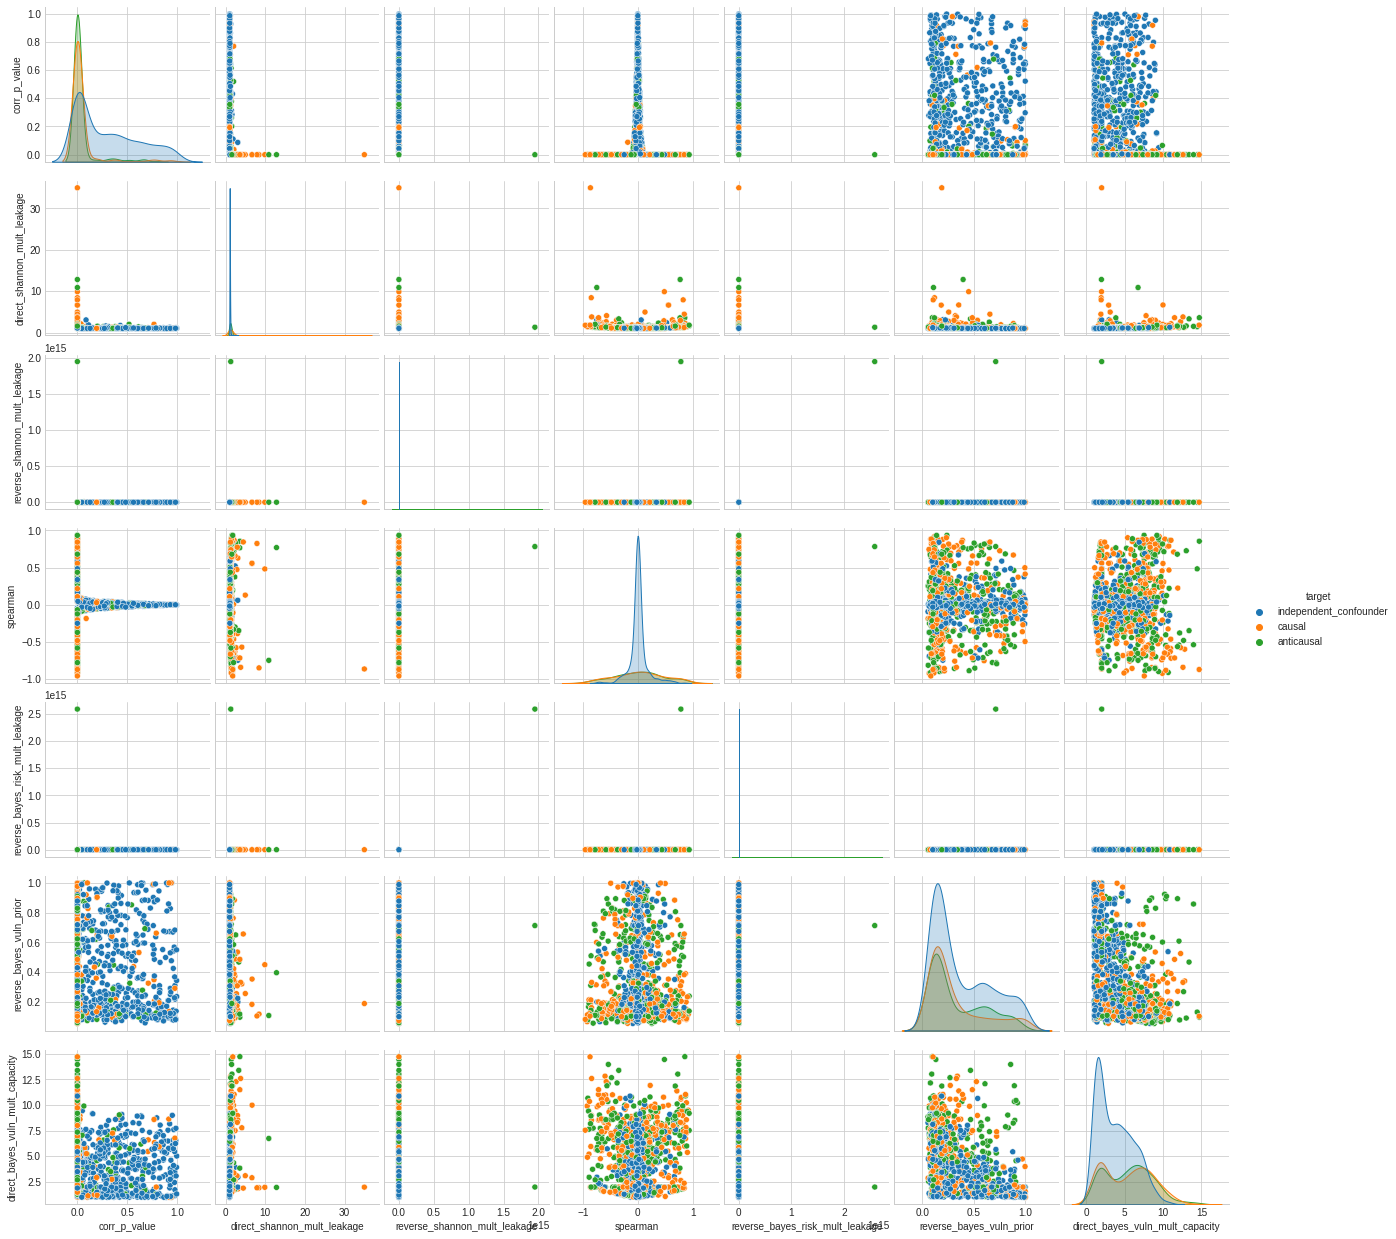

In [31]:
n_cols = 7
target_col = 'target'
selected_cols = (cols[clf.best_estimator_.feature_importances_.argsort()[::-1]][:n_cols]).tolist()
sns.pairplot(df_test[selected_cols + [target_col]], hue=target_col)
plt.show()

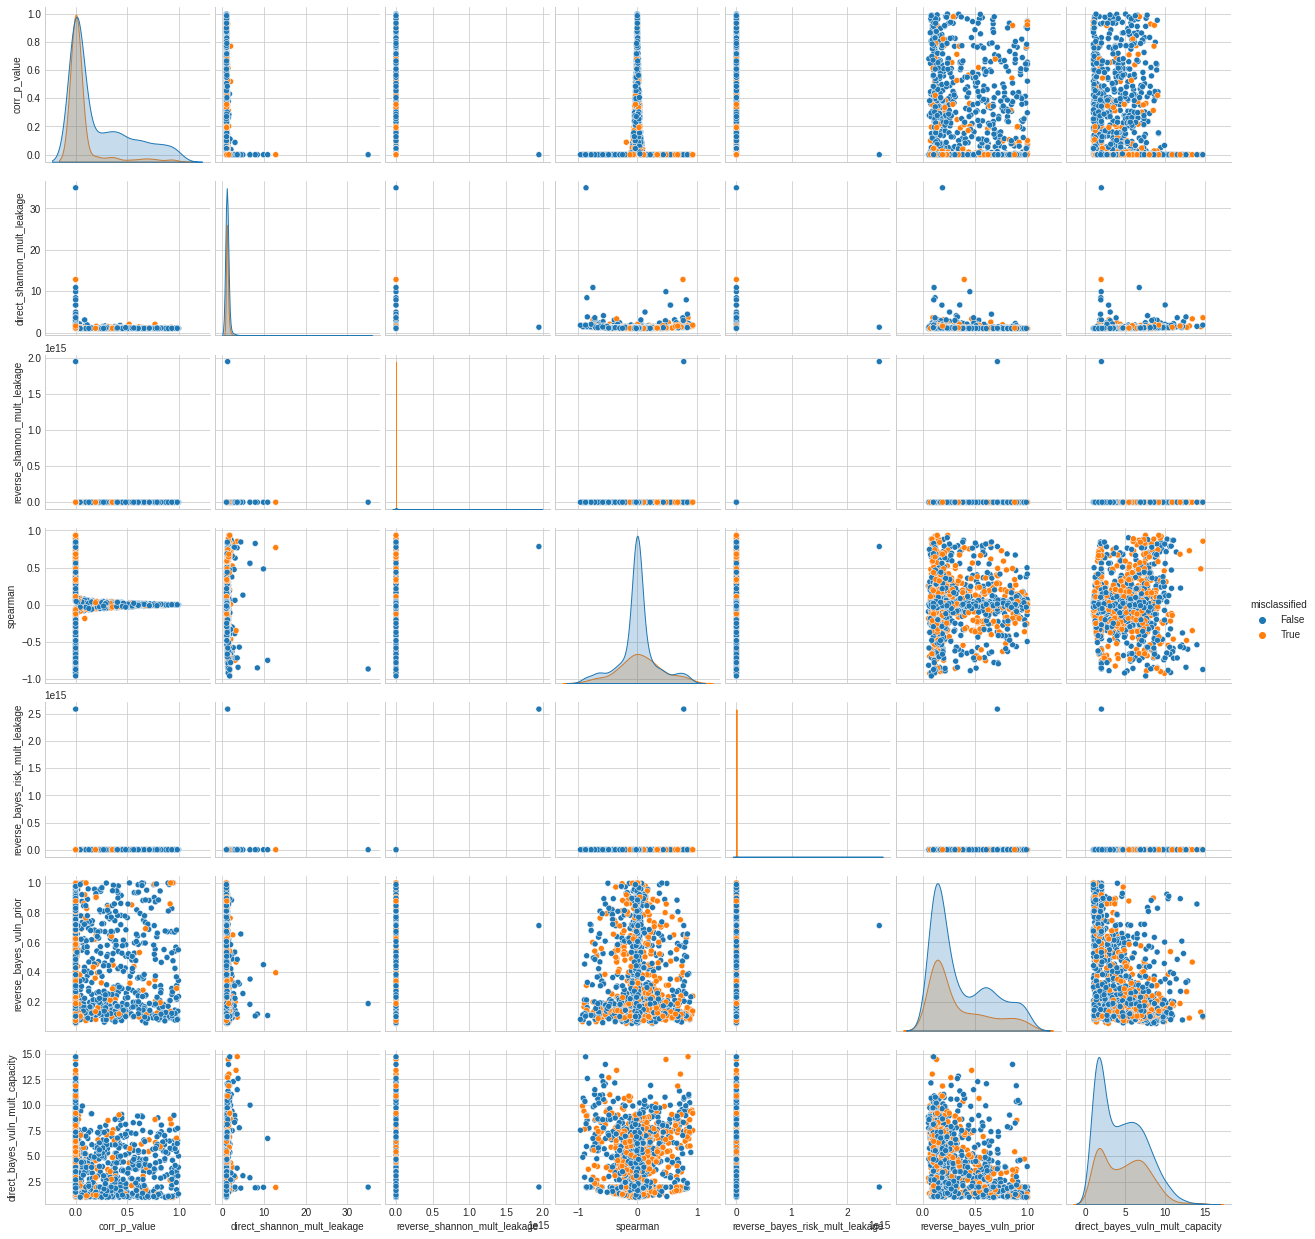

In [32]:
n_cols = 7
target_col = 'misclassified'
selected_cols = (cols[clf.best_estimator_.feature_importances_.argsort()[::-1]][:n_cols]).tolist()
sns.pairplot(df_test[selected_cols + [target_col]], hue=target_col)
plt.show()

## Shap Values

In [78]:
import shap

In [79]:
explainer = shap.TreeExplainer(clf.best_estimator_)

In [80]:
shap_values = explainer.shap_values(X_test)

In [81]:
labels = df_X.columns

In [101]:
clf.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=3, n_estimators=500,
                       n_jobs=8)

In [120]:
clf_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)
clf_tree.fit(pd.DataFrame(X_train, columns=labels), y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)

In [103]:
from sklearn.tree import plot_tree

In [121]:
labels[clf_tree.feature_importances_.argsort()[::-1]]

Index(['direct_shannon_mult_leakage', 'direct_bayes_vuln_prior',
       'reverse_bayes_risk_mult_leakage', 'reverse_bayes_vuln_mult_capacity',
       'direct_bayes_vuln_posterior', 'reverse_shannon_posterior',
       'reverse_bayes_vuln_mult_leakage_normalized_perf',
       'reverse_bayes_vuln_add_leakage', 'reverse_bayes_vuln_mult_leakage',
       'direct_bayes_risk_mult_leakage', 'reverse_shannon_mult_leakage',
       'direct_shannon_posterior', 'direct_bayes_vuln_add_leakage',
       'reverse_bayes_vuln_min_entropy_leakage',
       'direct_bayes_vuln_min_entropy_leakage',
       'direct_bayes_vuln_mult_leakage_normalized_perf',
       'direct_bayes_vuln_mult_capacity', 'reverse_bayes_vuln_posterior',
       'reverse_bayes_vuln_prior', 'direct_bayes_vuln_mult_leakage_normalized',
       'reverse_bayes_vuln_mult_leakage_normalized',
       'direct_bayes_vuln_mult_leakage_perf',
       'reverse_bayes_vuln_mult_leakage_perf',
       'direct_bayes_vuln_mult_leakage'],
      dtype='object

In [122]:
clf_tree.feature_importances_.argsort()[::-1]

array([ 4, 16,  3, 13, 14,  7, 23,  9,  1,  2,  5,  6,  8, 11, 10, 22, 12,
       15, 17, 18, 19, 20, 21,  0])

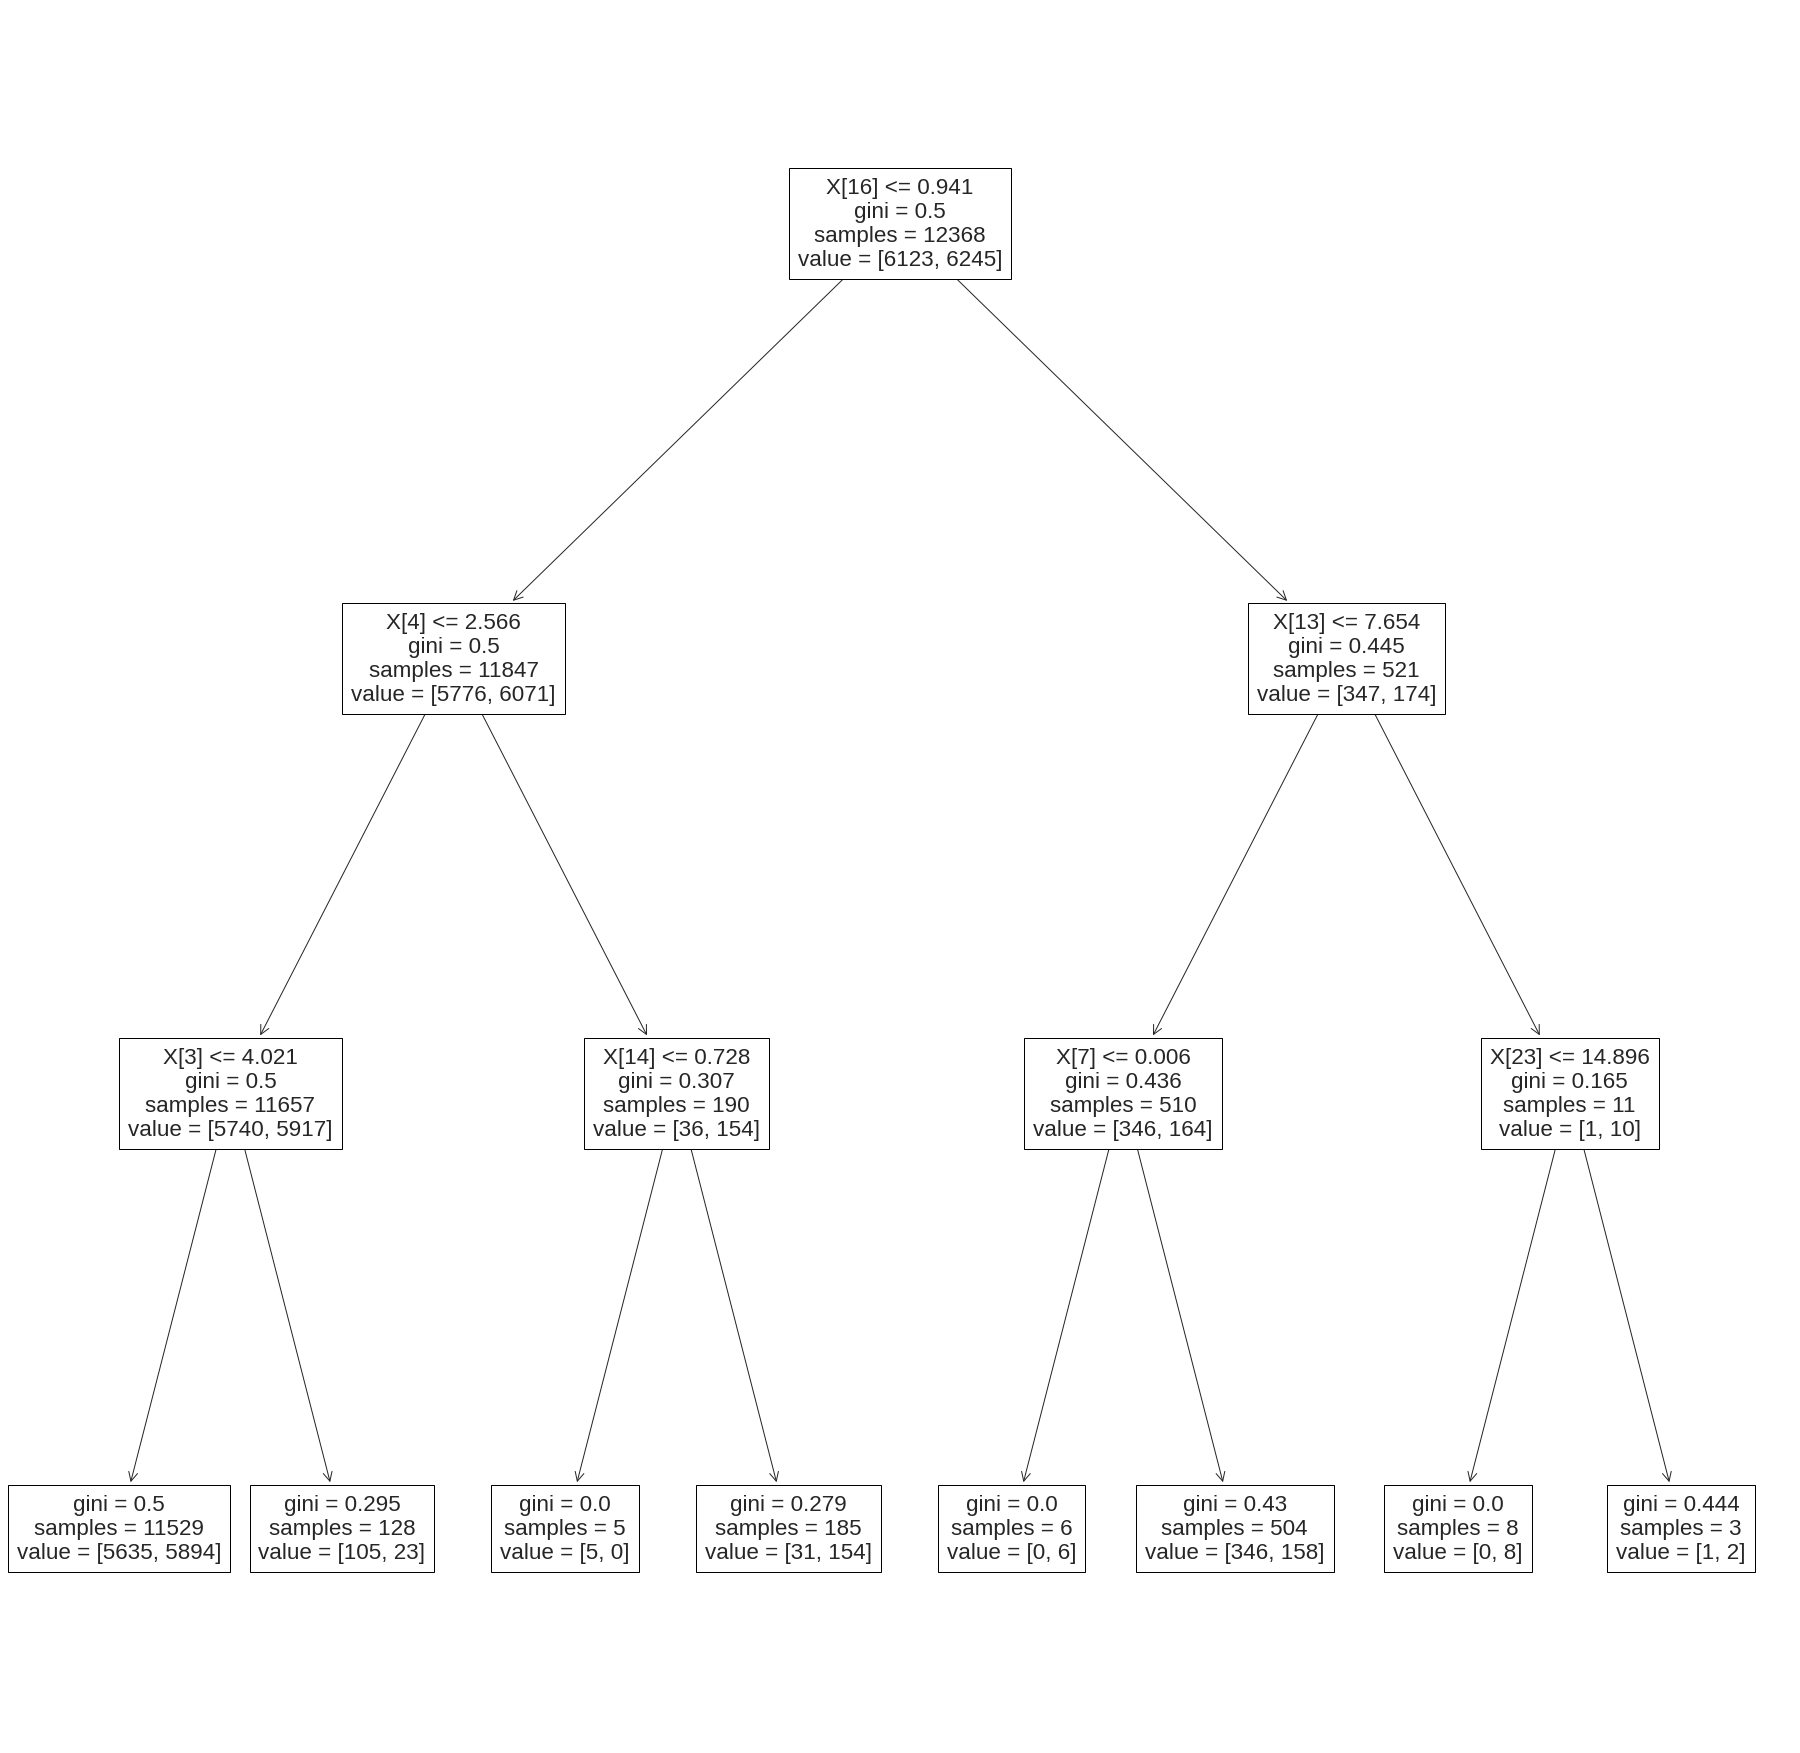

In [123]:
fig, ax = plt.subplots(figsize=(32, 32))
plot_tree(clf_tree, max_depth=3, ax=ax);
plt.show()

In [100]:
labels[clf.best_estimator_.feature_importances_.argsort()[::-1]]

Index(['reverse_bayes_vuln_prior', 'direct_bayes_vuln_prior',
       'reverse_shannon_mult_leakage', 'direct_shannon_mult_leakage',
       'direct_bayes_vuln_posterior', 'reverse_bayes_vuln_posterior',
       'direct_bayes_risk_mult_leakage', 'direct_shannon_posterior',
       'reverse_bayes_risk_mult_leakage', 'reverse_shannon_posterior',
       'reverse_bayes_vuln_mult_leakage_normalized',
       'direct_bayes_vuln_mult_leakage_normalized_perf',
       'direct_bayes_vuln_mult_leakage_normalized',
       'reverse_bayes_vuln_mult_leakage_normalized_perf',
       'reverse_bayes_vuln_add_leakage', 'reverse_bayes_vuln_mult_capacity',
       'direct_bayes_vuln_add_leakage', 'direct_bayes_vuln_mult_leakage_perf',
       'direct_bayes_vuln_mult_capacity',
       'reverse_bayes_vuln_mult_leakage_perf',
       'reverse_bayes_vuln_min_entropy_leakage',
       'reverse_bayes_vuln_mult_leakage',
       'direct_bayes_vuln_min_entropy_leakage',
       'direct_bayes_vuln_mult_leakage'],
      dtype=

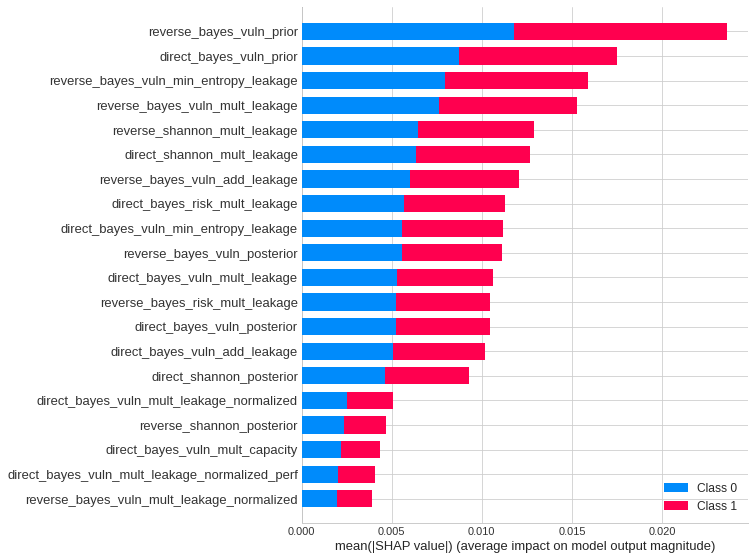

In [97]:
shap.summary_plot(shap_values, X_test, feature_names=labels)

In [84]:
df_test = pd.DataFrame(X_test, columns=labels)

In [85]:
df_test['y_test'] = y_test
df_test['y_pred'] = y_pred

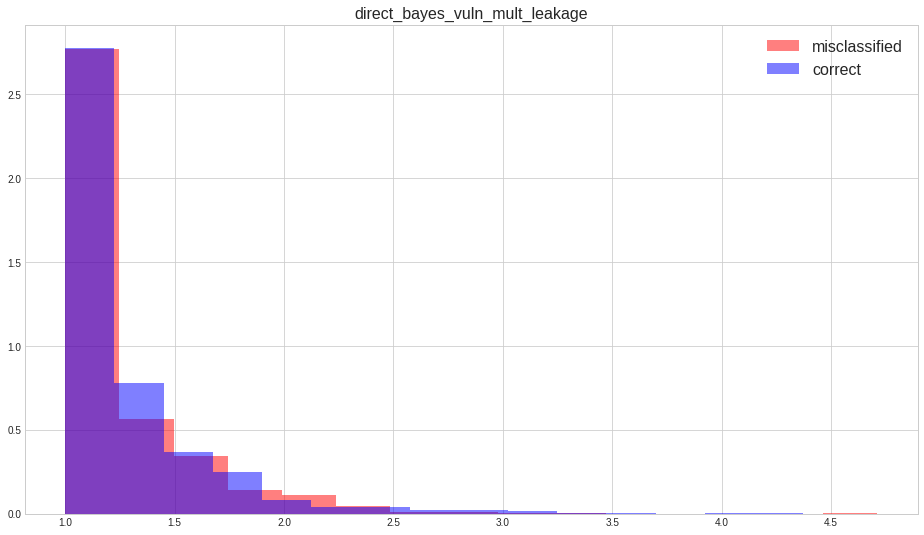

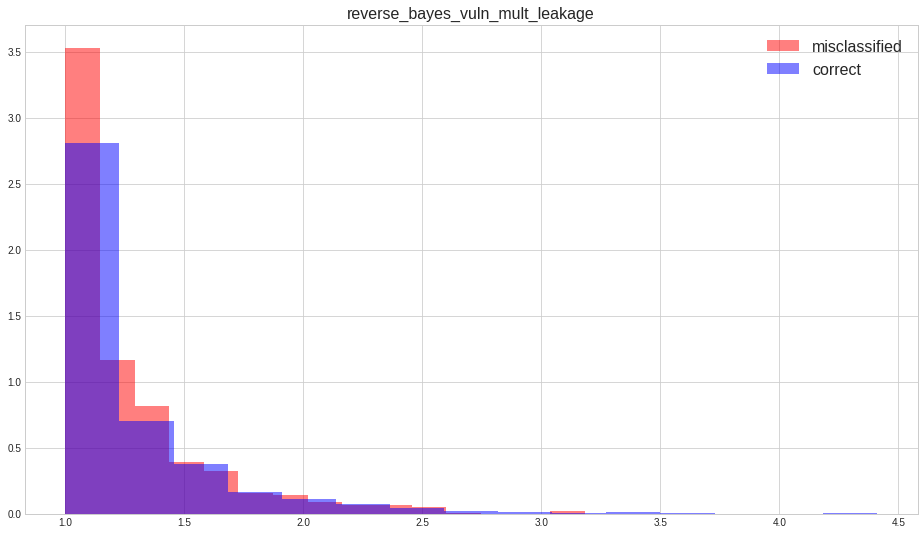

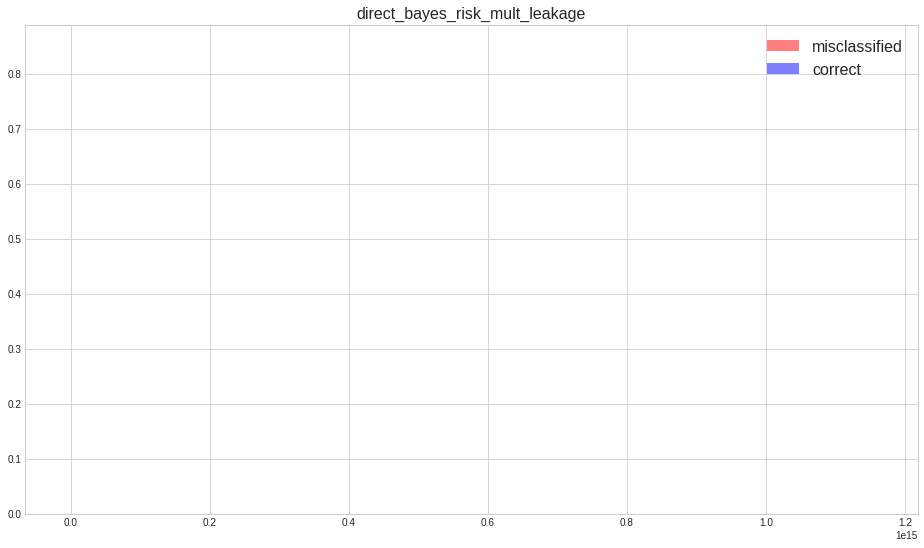

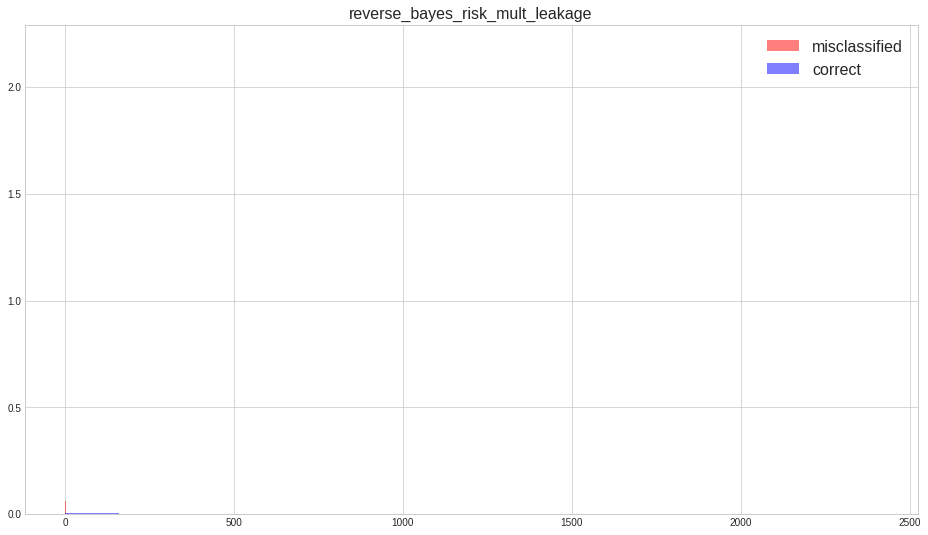

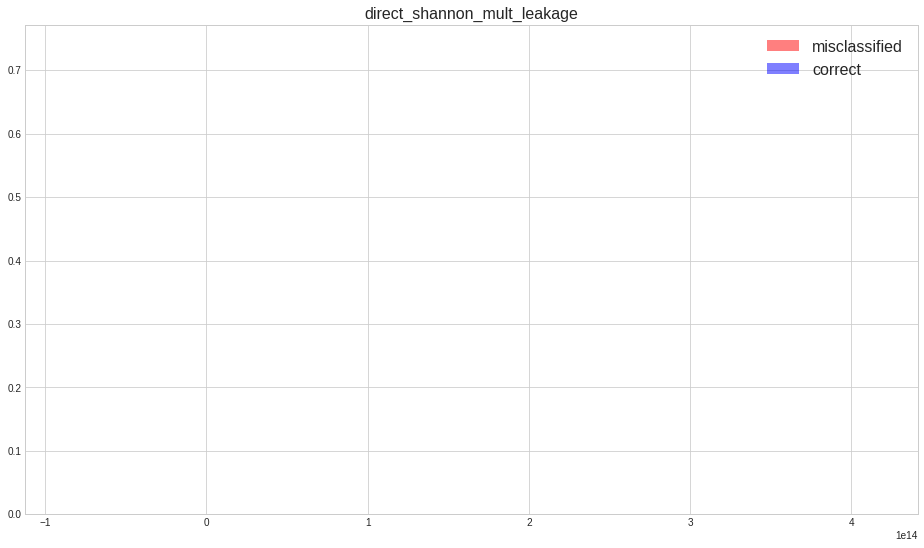

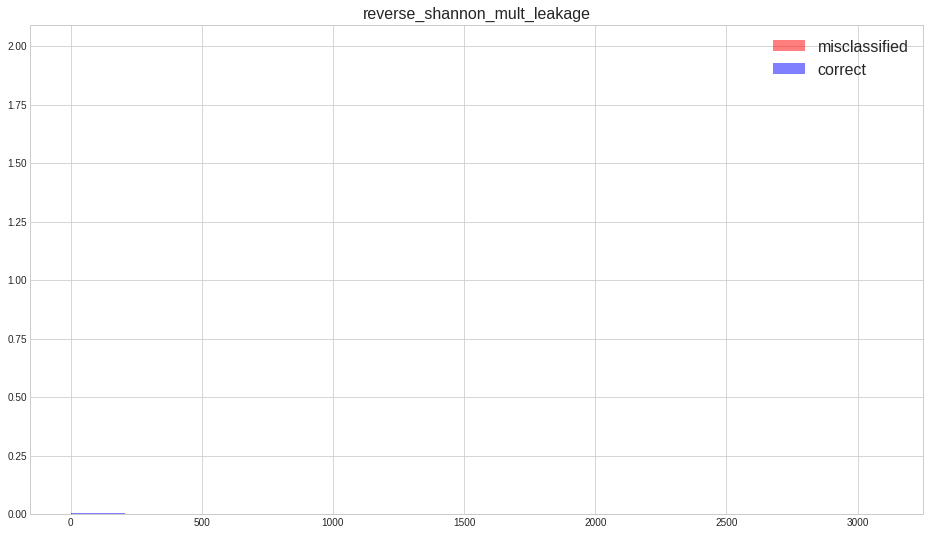

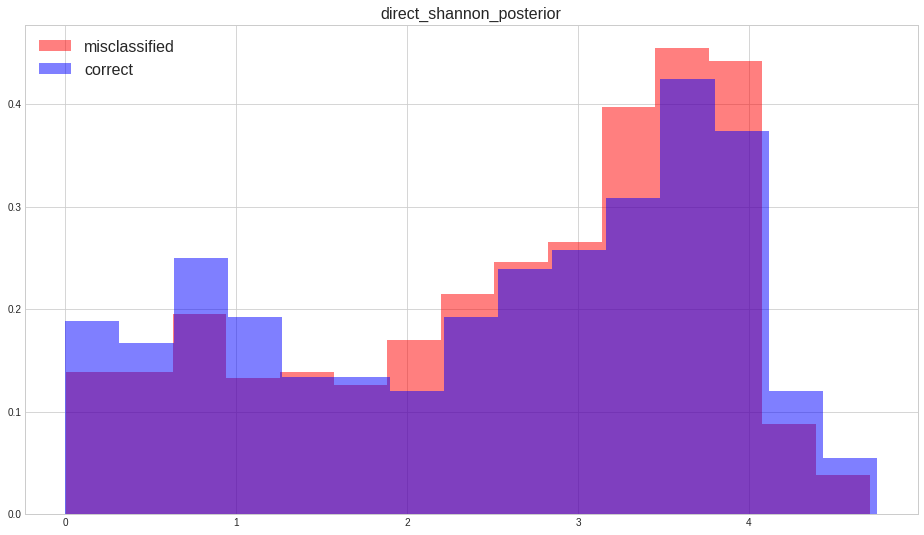

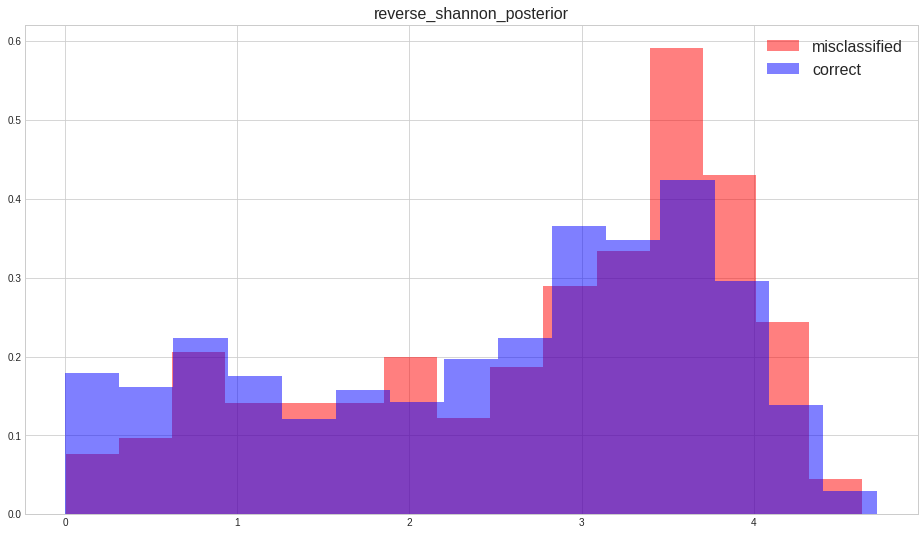

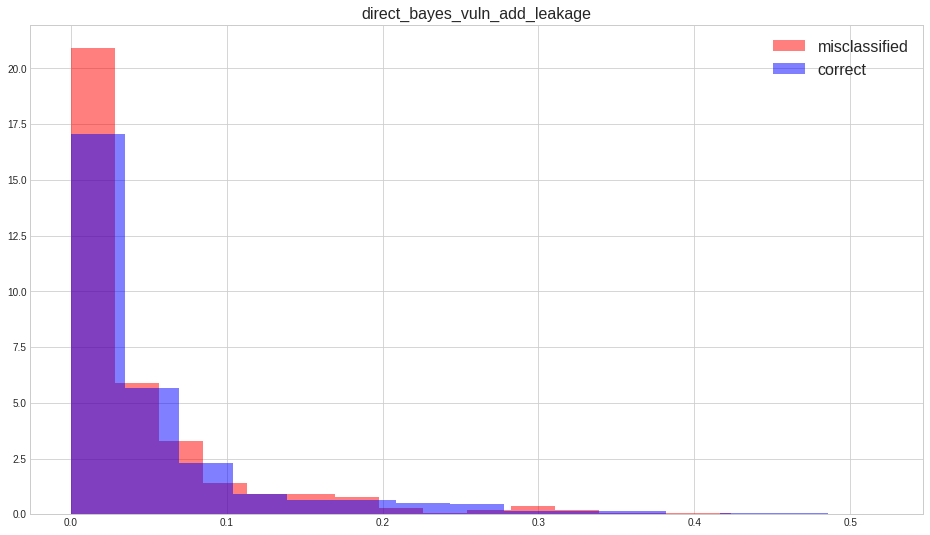

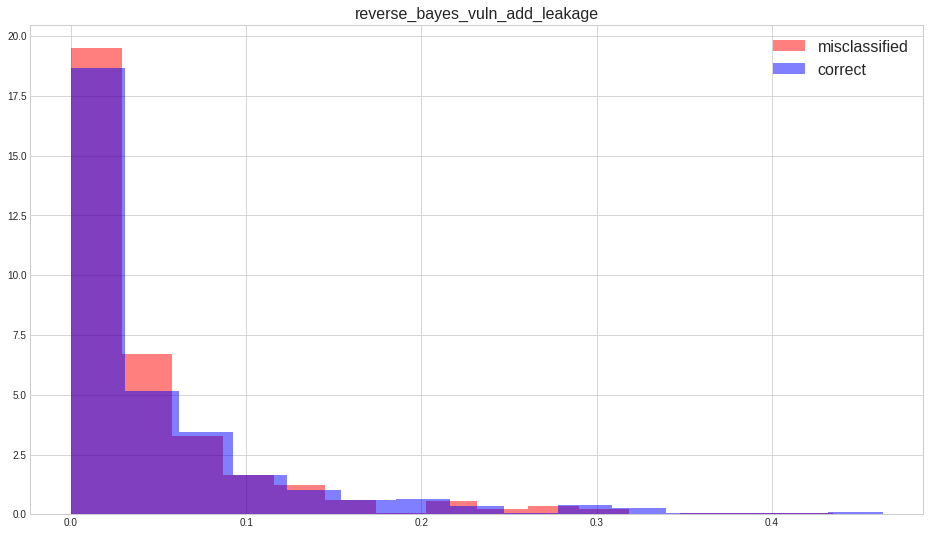

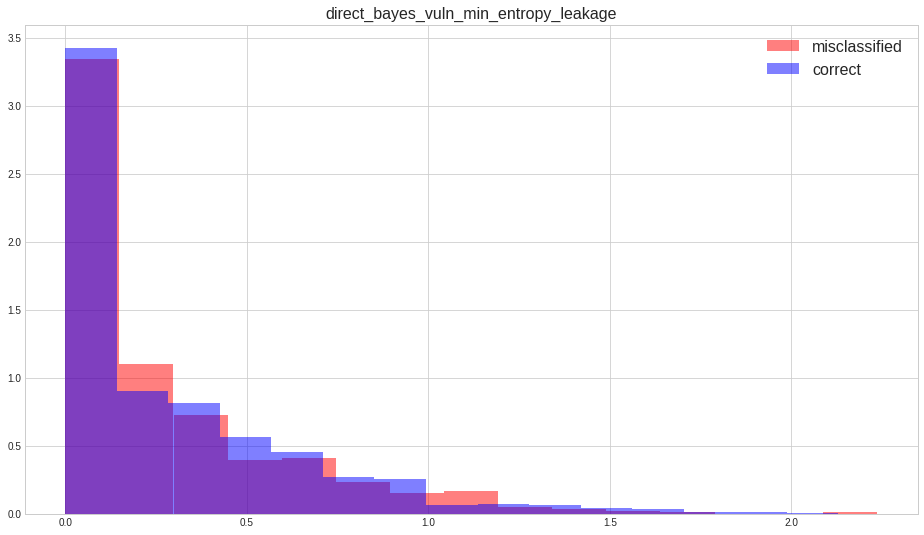

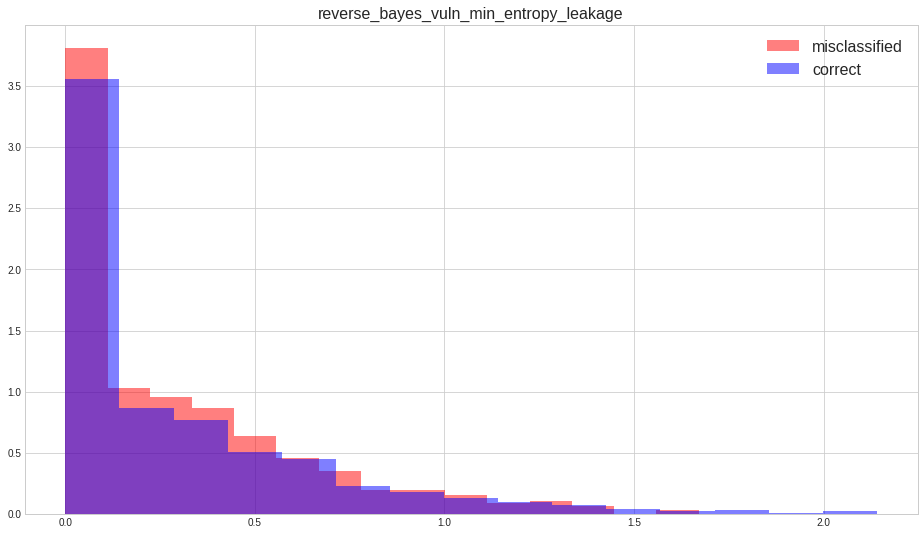

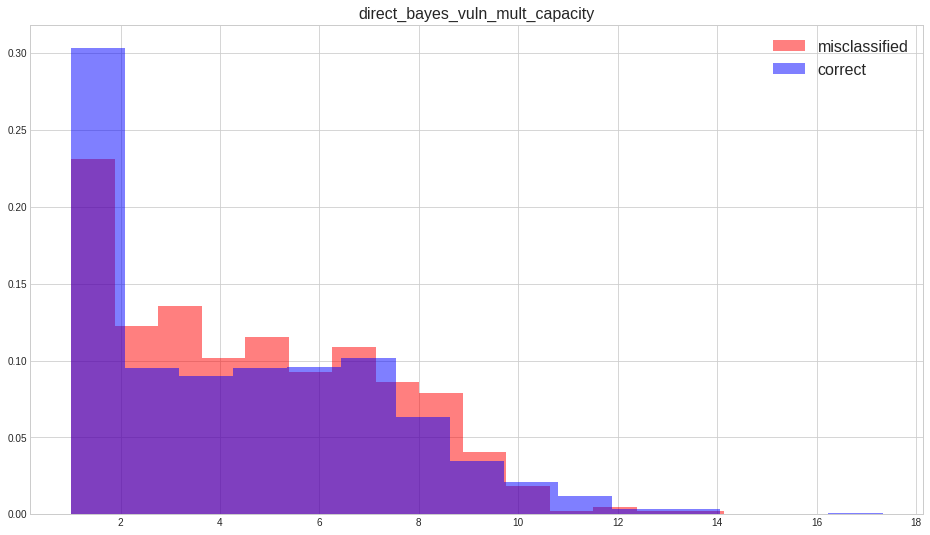

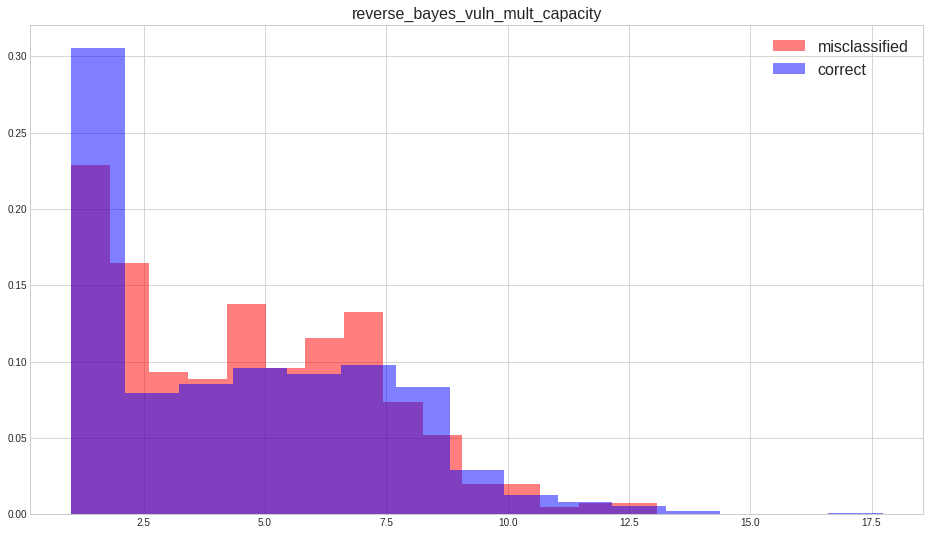

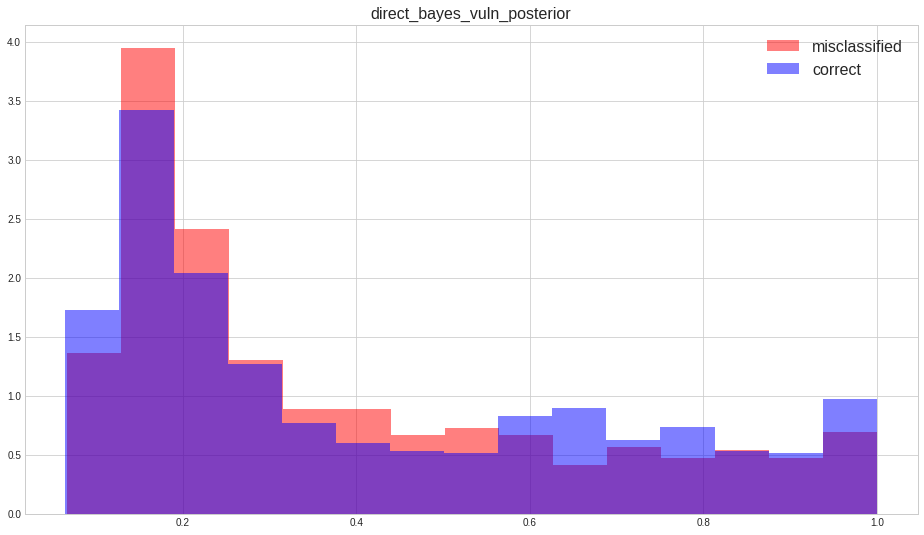

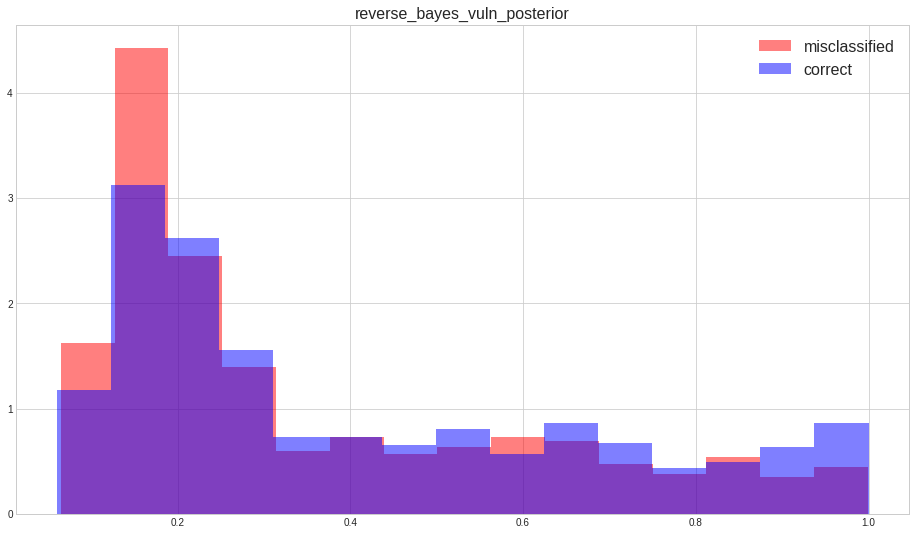

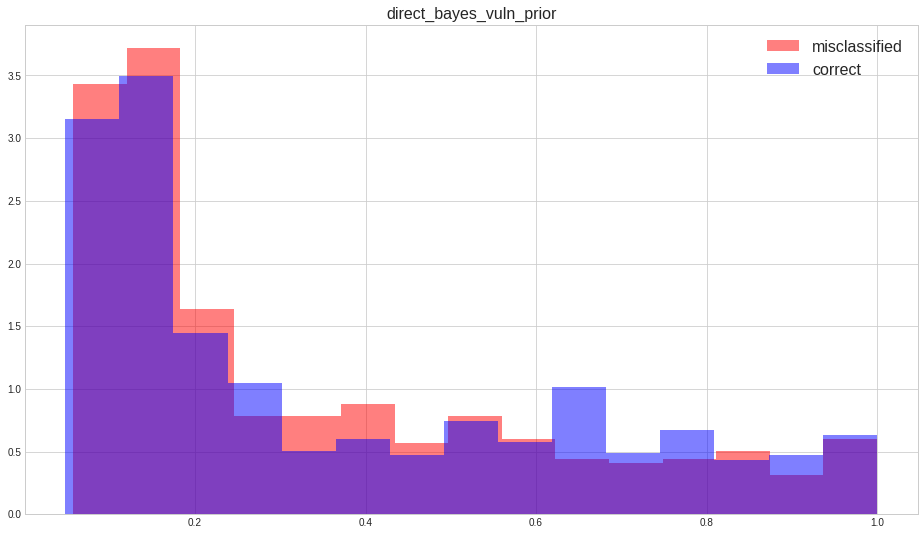

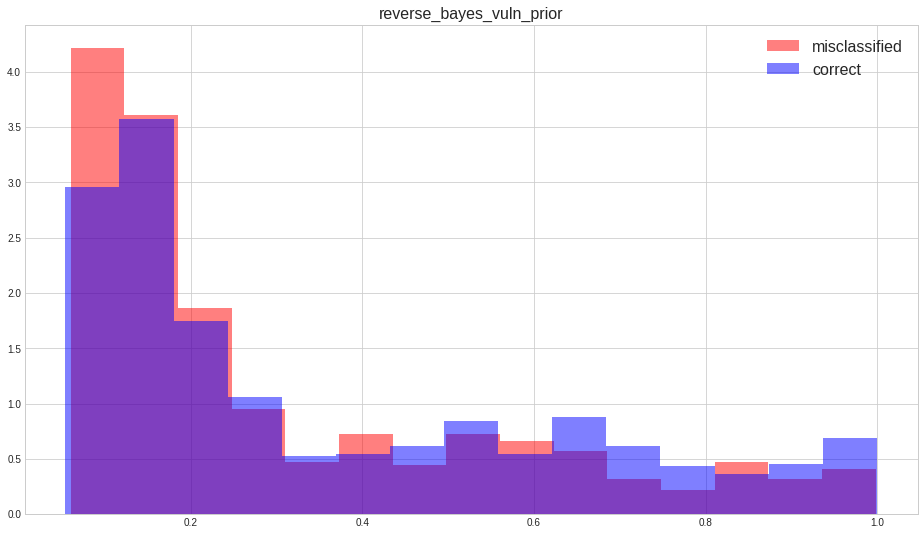

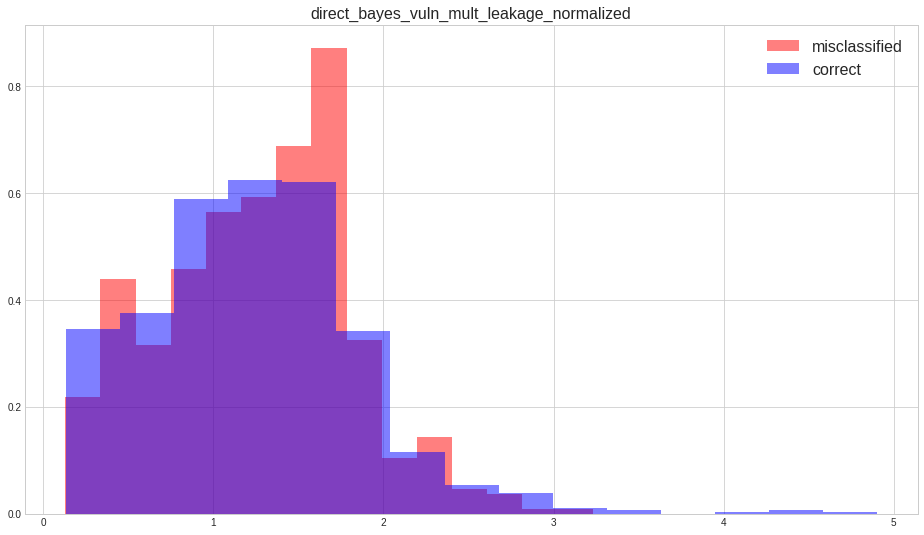

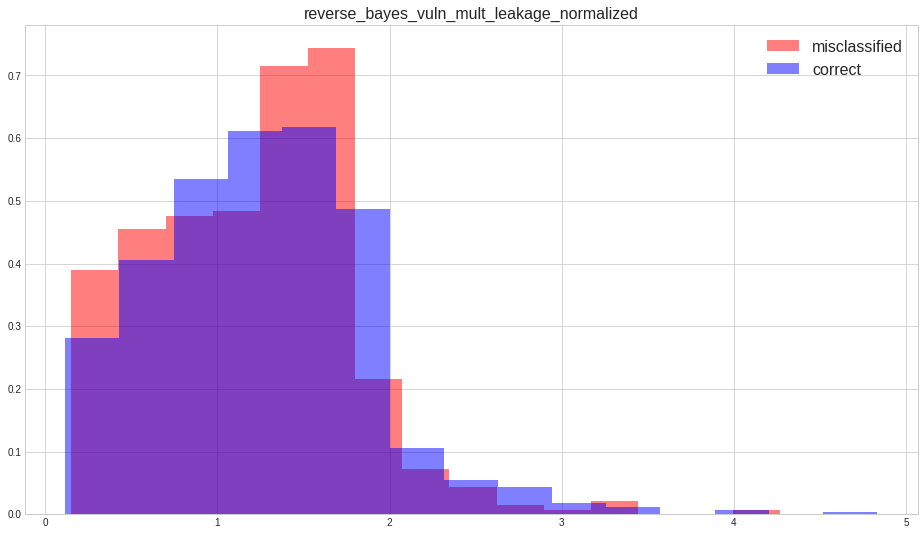

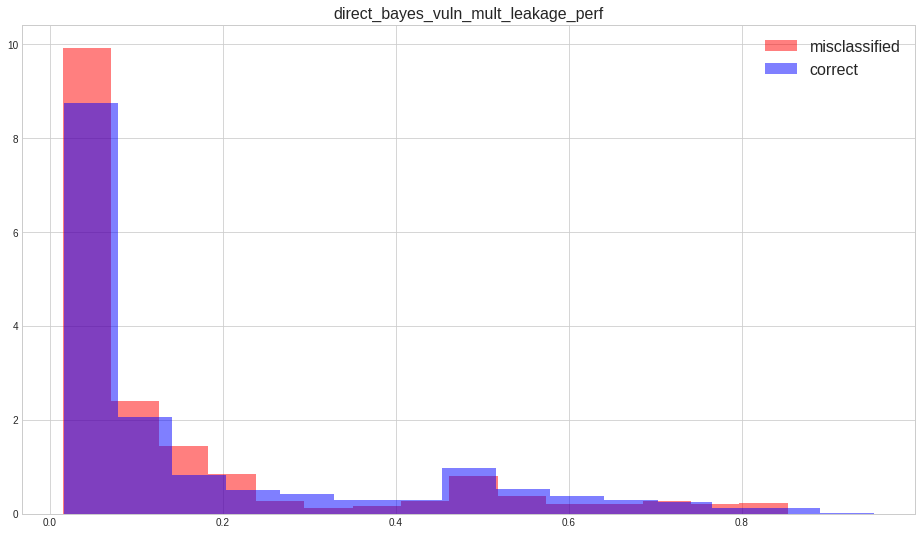

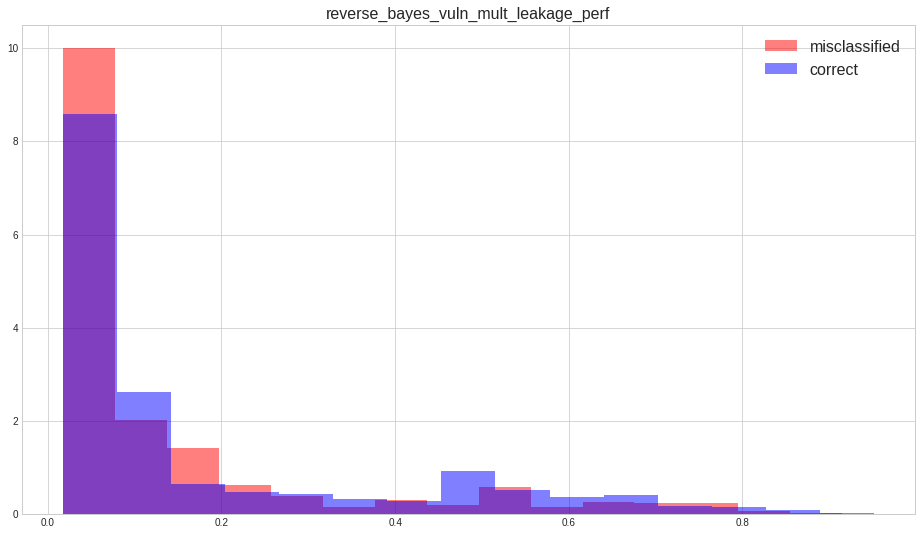

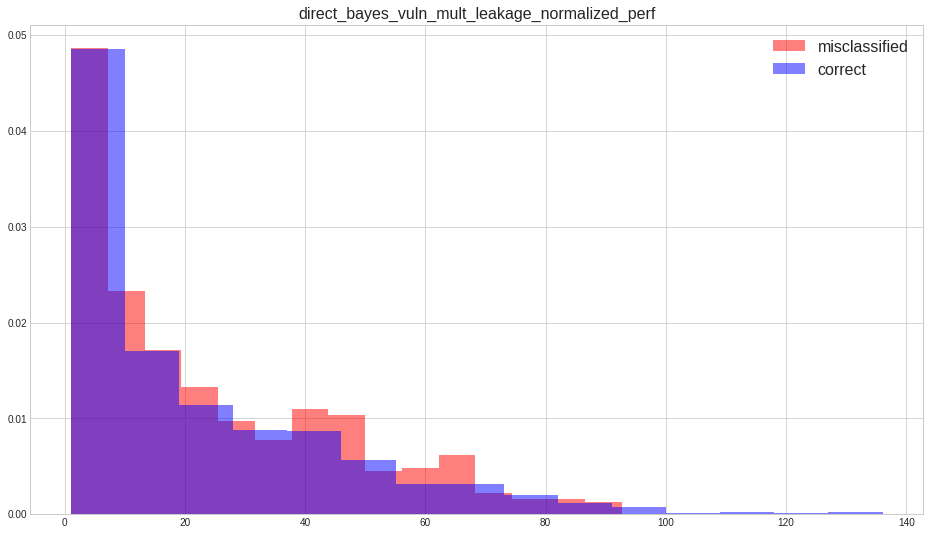

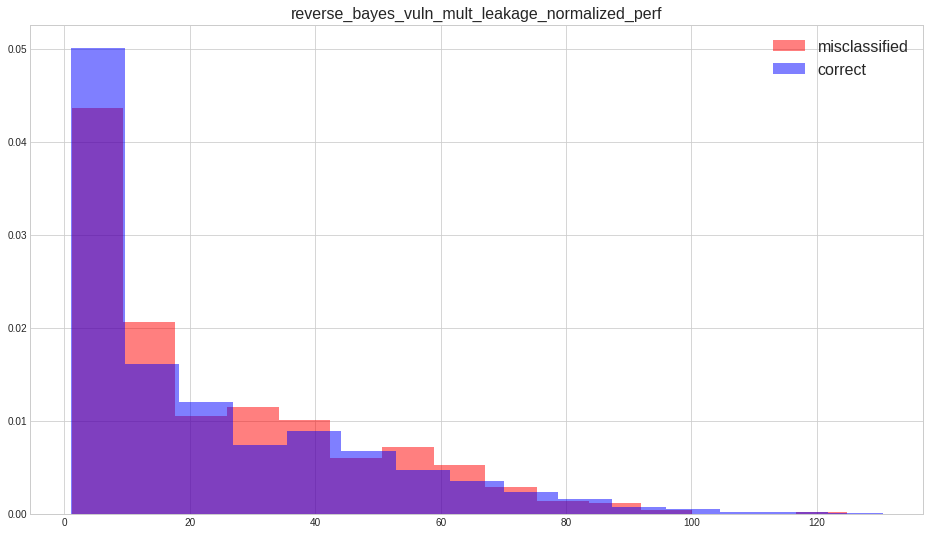

In [95]:
feature = "direct_bayes_vuln_prior"
for feature in labels:
    plt.figure(figsize=(16, 9))
    plt.hist(df_test.query("y_pred != y_test")[feature], label='misclassified', alpha=0.5, color='red', density=True, bins=15)
    plt.hist(df_test.query("y_pred == y_test")[feature], label='correct', alpha=0.5, color='blue', density=True, bins=15)
    plt.title(feature, fontsize=16)
    plt.legend(fontsize=16)
    plt.show()